Pour qu'il n'ai pas de problème lors des importations

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

# Importation

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from models.utils.utils_torch import virtual_coil_reconstruction, load_and_transform 
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.varnet import VarNet 
from fastmri.data import transforms


# Download & Transform

In [88]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

# Renvoie un Tensor Pytorch 
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

# Renvoie une image Single Coil
image = virtual_coil_reconstruction(images_multicoil)

# Coil = 1 
image = image.unsqueeze(1)

# Kspace of the new image
kspace = torch.fft.fft2(image)

print(kspace_multicoil.shape)
print(images_multicoil.shape)
print(image.shape)
print(kspace.shape)

torch.Size([16, 16, 640, 320])
torch.Size([16, 16, 640, 320])
torch.Size([16, 1, 640, 320])
torch.Size([16, 1, 640, 320])


Show all the batch

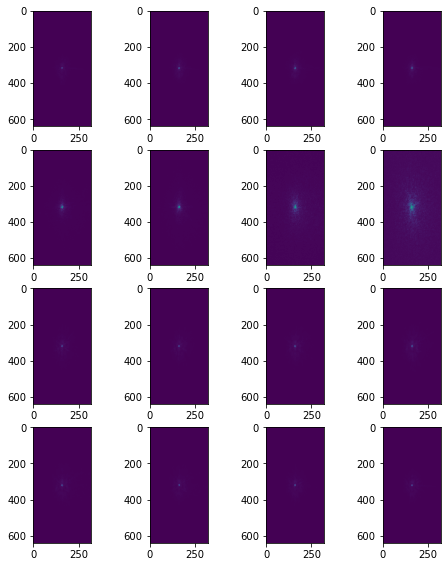

In [73]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show image (abs(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(image[i, 0, :,:]))

# # Show image's phase (angle(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(image[i, 0, :,:]))

# # Show kspace (abs(kspace))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(kspace[i,0, :,:]))


# Mask application

In [89]:
#  Parametres
mask_type = "random"
center_fractions = [0.08]
accelerations = [4]

# Function de Mask
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

# Reajustement shape pour bien avoir un mask en fonction de l'Ordonnée
kspace = kspace.unsqueeze(-1)

# Application
# # Ici on peux faire un mask par batch . A voir.
mask, _ = mask_func(kspace.shape)
masked_kspace = kspace * mask
zero_filled =torch.fft.ifftn(masked_kspace)

# Pour l'entrainement
target = image.abs().unsqueeze(1)

print("kspace : ",kspace.shape)
print("mask : ",mask.shape)
print("kspace de zero_filled : ", masked_kspace.shape)
print("zero_filled, ce sera l'input : ", zero_filled.shape)
print("target : ", target.shape)

kspace :  torch.Size([16, 1, 640, 320, 1])
mask :  torch.Size([1, 1, 1, 320, 1])
kspace de zero_filled :  torch.Size([16, 1, 640, 320, 1])
zero_filled, ce sera l'input :  torch.Size([16, 1, 640, 320, 1])
target :  torch.Size([16, 1, 1, 640, 320])


Show all the batch

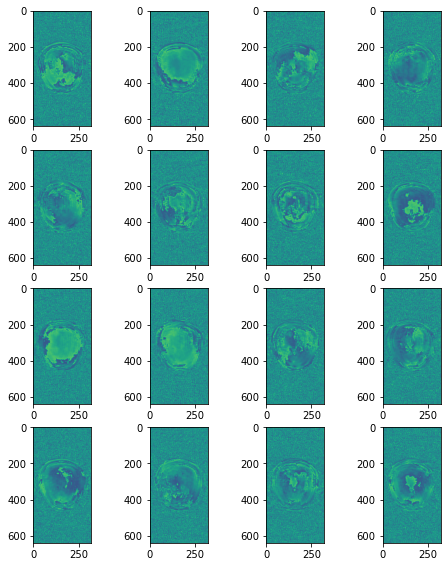

In [90]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace (abs(masked_kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(masked_kspace[i, 0, :,:]))

# # Show zero-filled (abs(zero_filled))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(zero_filled[i, 0, :,:]))

# # Show zero-filled's phase(angle(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.angle(zero_filled[i,0, :,:]))


Reajustement shape

In [91]:
# mask's shape
new_size = (zero_filled.shape[0],) + mask.size()[1:]
masked_data = mask.expand(new_size)

# zero_filled's shape
zero_filled = zero_filled.squeeze(-1)

print("mask : ",masked_data.shape)
print("input : ",zero_filled.shape)

mask :  torch.Size([16, 1, 1, 320, 1])
input :  torch.Size([16, 1, 640, 320])


# Varnet model

In [92]:
# Parametre
chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True
lr = 0.0001

# Création d'une nouvelle dimension pour dissocier la partie réel et imaginaire des complex
shape_new = image.shape + (2,)
input = torch.zeros(shape_new)
input[..., 0] = zero_filled.real
input[..., 1] = zero_filled.imag 
print(input.shape)

# Model
varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)

# Loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(varnet.parameters(), lr=lr)
loss_list = []

# Train
num_epochs = 54
for epoch in range(num_epochs):
    input = Variable(input)
    target = Variable(target)

    optimizer.zero_grad()
    outputs = varnet(input, masked_data.byte())
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}]')

torch.save(varnet.state_dict(), 'fastmri_varnet_model.pth')

torch.Size([16, 1, 640, 320, 2])


/home/lo276838/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1, 1, 640, 320])) that is different to the input size (torch.Size([16, 640, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


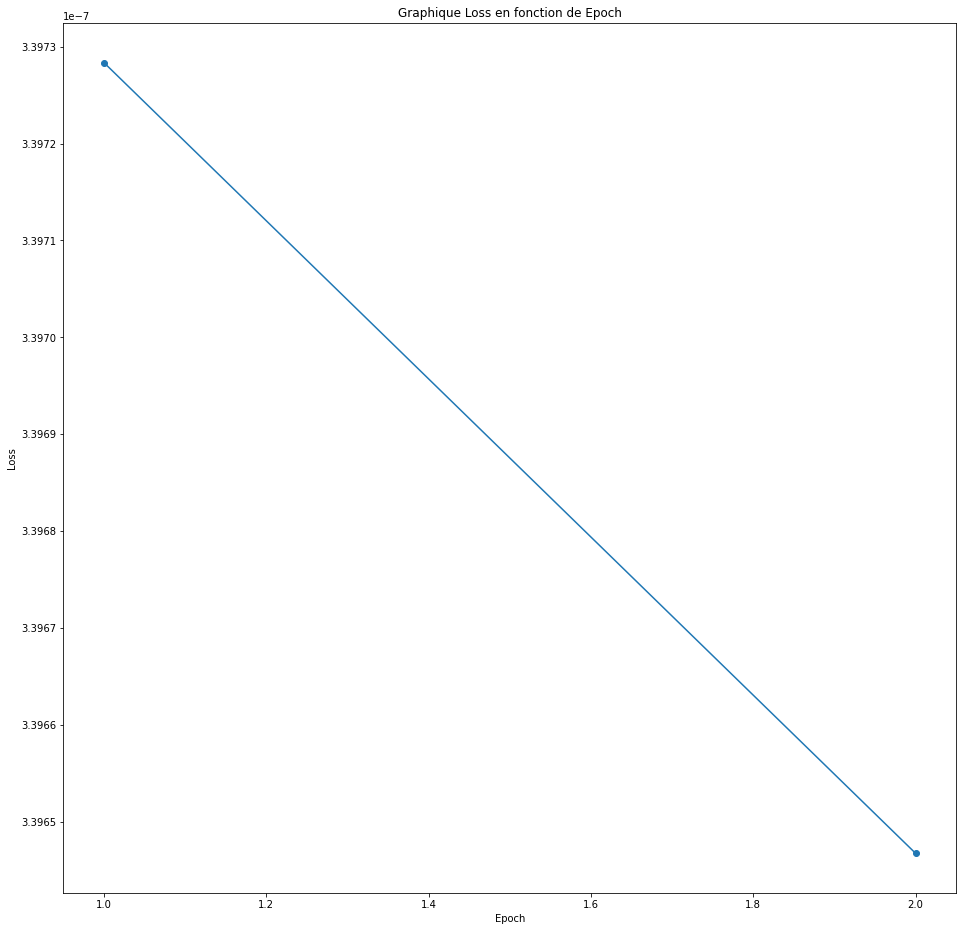

In [87]:
indices = list(range(1, len(loss_list) + 1))

plt.plot(indices, loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphique Loss en fonction de Epoch')
plt.show()
